In [76]:
# run from suite2p environment!!
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.io as sio
import sys
sys.path.append('../helpers')
import loadmat as lm
from sklearn import linear_model
from scipy import signal
from sklearn.model_selection import cross_val_score, cross_validate
import os
from sklearn.metrics import make_scorer, confusion_matrix
import glob
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from helpers import preprocess

In [37]:
files = glob.glob('Z:/giocomo/attialex/NP_DATA/np*_gain_*.mat')
for iF in files:
    print(iF)

Z:/giocomo/attialex/NP_DATA\npG1_1219_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npG2_1211_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npG2_1213_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npG4_1203_gain_2.mat
Z:/giocomo/attialex/NP_DATA\npG5_1207_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npH3_0329_baseline_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npH3_0401_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npH3_0403_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npH4_0318_baseline_with_gain_1_KS2.mat
Z:/giocomo/attialex/NP_DATA\npH5_0325_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npH5_0327_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npI1_0415_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npI1_0418_gain_3.mat
Z:/giocomo/attialex/NP_DATA\npI3_0420_baseline_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npI3_0422_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npI4_0420_baseline_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npI4_0422_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npI5_0415_gain_1.mat
Z:/giocomo/attialex/NP_DATA\npI5_0418_gain_1.mat
Z:/giocomo/attialex/NP_D

In [38]:
test_data = lm.loadmat(files[1])

In [39]:
test_data = preprocess(test_data)

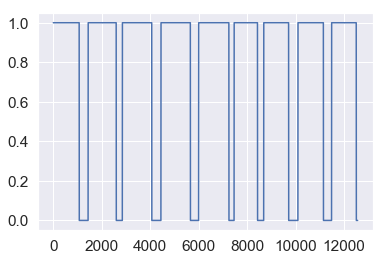

In [40]:
bl_trials = np.nonzero(np.all([test_data['trial_contrast']==100, test_data['trial_gain']==1],axis = 0))
trialidx = np.isin(test_data['trial_resampled'],bl_trials)
plt.plot(trialidx)

In [41]:
model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
model.fit(test_data['spikecount'][trialidx,:],test_data['posx_bin'][trialidx])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
for gain in [0.8, 0.7, 0.6, 0.5]:
    bl_trials = np.nonzero(np.all([test_data['trial_contrast']==100, test_data['trial_gain']==gain],axis = 0))
    trialidx = np.isin(test_data['trial_resampled'],bl_trials)
    Yhat = model.predict(test_data['spikecount'][trialidx,:])
    err=mean_absolute_error(Yhat,test_data['posx_bin'][trialidx])
    print(err)
    err = Yhat-test_data['posx_bin'][trialidx]
    print(err.mean())
    

2.9281989570798235
-0.6179302045728039
6.241852487135506
-0.49914236706689535
13.36935166994106
-2.9096267190569747
12.852724594992637
-2.7378497790868925
14.820445609436435
-2.600262123197903


In [67]:
bl_trials = np.nonzero(np.all([test_data['trial_contrast']==100, test_data['trial_gain']==0.5],axis = 0))
trialidx = np.isin(test_data['trial_resampled'],bl_trials)
Yhat = model.predict(test_data['spikecount'][trialidx,:])
conf_matrix=confusion_matrix(test_data['posx_bin'][trialidx],Yhat)

In [56]:
conf_matrix.shape

(82, 82)

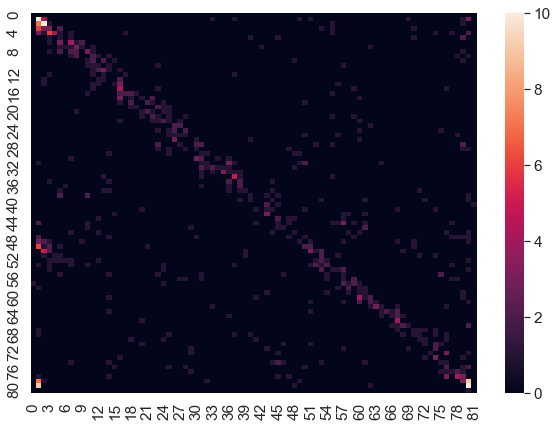

In [68]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
     
df_cm = pd.DataFrame((conf_matrix), range(82),
                  range(82))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=False,annot_kws={"size": 3},vmax=10)# font size
plt.savefig('C:/temp/out_error_cm1.png')

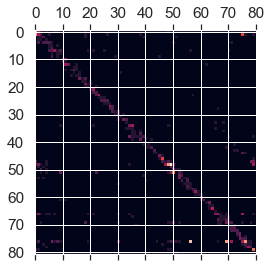

In [35]:
plt.matshow(array)
plt.savefig('C:/temp/out_error_cm3.pdf')

In [77]:
def eval_and_train(dataset):
    bl_trials = np.nonzero(np.all([dataset['trial_contrast']==100, dataset['trial_gain']==1],axis = 0))
    trialidx = np.isin(dataset['trial_resampled'],bl_trials)
    scoring = {'prec_macro': 'precision_macro','mae_macro': make_scorer(mean_absolute_error)}
    model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
    #scores = cross_val_score(model, , cv=5)
    scores = cross_validate(model,dataset['spikecount'][trialidx,:],dataset['posx_bin'][trialidx],scoring=scoring, cv=5,return_estimator=True)
    
    model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
    model.fit(dataset['spikecount'][trialidx,:],dataset['posx_bin'][trialidx])
    return model,scores

In [82]:
def score_baseline_model(model,test_data):
    ma_errors = []
    m_errors = []
    precision = []
    confusion_matrix = []
    for gain in [1, 0.8, 0.7, 0.6, 0.5]:
        

        bl_trials = np.nonzero(np.all([test_data['trial_contrast']==gain, test_data['trial_gain']==1],axis = 0))
        trialidx = np.isin(test_data['trial_resampled'],bl_trials)
        if trialidx.sum()>0:
            #print(model.score(test_data['spikecount'][trialidx,:],test_data['posx_bin'][trialidx]))
            Yhat = model.predict(test_data['spikecount'][trialidx,:])
            ma_errors.append(mean_absolute_error(Yhat,test_data['posx_bin'][trialidx]))
            precision.append(model.score(test_data['spikecount'][trialidx,:],test_data['posx_bin'][trialidx]))
            err = Yhat-test_data['posx_bin'][trialidx]
            m_errors.append(err.mean())
            c_matrix=confusion_matrix(test_data['posx_bin'][trialidx],Yhat)
            confusion_matrix.append(c_matrix)
        else: 
            ma_errors.append(np.nan)
            m_errors.append(np.nan)
            precision.append(np.nan)
            confusion_matrix.append(np.nan)
        
        
    return (ma_errors,m_errors,precision,confuxion_matrix)

In [ ]:
files = glob.glob('Z:/giocomo/attialex/NP_DATA/np*_gain_*.mat')
contrast_scores = []
baseline_scores = []
for iF in files[0:3]:
    if not 'baseline' in iF:
        dataset = lm.loadmat(iF)
        dataset = preprocess(dataset)
        (model, bl_scores) = eval_and_train(dataset)
        tmp_scores = score_baseline_model(model,dataset)
        gain_scores.append(tmp_scores)
        baseline_scores.append(bl_scores)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
